In [68]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.fftpack import fftn, ifftn

### Configuration options

In [70]:
rotatedFrame = True
canyon = False
hills = 'x-hills'
rest = False

plotting = True
Uinit = False

exp_names = {
    'rotatedFrame': ['unrotated', 'rotated'],
    'canyon': ['', '_canyon'],
    'hills': ['', '_'+hills],
    'rest': ['', '_rest']
}

experiment_path = "../../MITgcm/experiments/"
experiment_name = (
    exp_names['rotatedFrame'][rotatedFrame] +
    exp_names['hills'][len(hills)!=0] + 
    exp_names['canyon'][canyon] +
    exp_names['rest'][rest]
)
input_path = experiment_path + experiment_name + '/input/'

input_path

'../../MITgcm/experiments/rotated_x-hills/input/'

### Physical parameters

In [71]:
# environmental parameters
N = 1.3e-3
f = 0.53e-4

gravity = 9.81
tAlpha = 2.e-4

# grid param
nx = 256
ny = 256
nz = 280

dx = 600
dy = 600
dz0 = 4
nz_vary_frac = 0.65

Lx = nx*dx
Ly = ny*dy

# topographic parameters
slopeAngle = 2.e-3
hill_height = 20.
xhill_length = Lx/3
yhill_length = Ly/3
canyon_width = 4.5e3
canyon_depth = 400.

# mixing parameters
d = 230
k0 = 5.2e-5
k1 = 1.8e-3

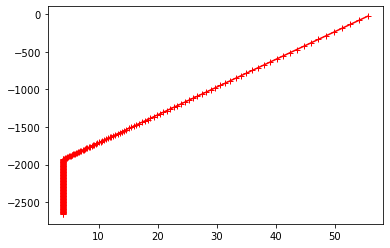

In [72]:
nz_vary = np.int(nz*nz_vary_frac)
dz = dz0 * np.ones((nz))[:,np.newaxis,np.newaxis]*np.ones((nz,ny,nx))
dz[nz_vary:,:,:] = dz[nz_vary,0,0]*1.0275**np.arange(0,nz-nz_vary,1.0)[:,np.newaxis,np.newaxis]*np.ones((nz-nz_vary,ny,nx))
Hz = sum(dz[:,0,0])

x = np.arange(dx/2.0,Lx,dx)[np.newaxis,np.newaxis,:]*np.ones((nz,ny,nx))
y = np.arange(dy/2.0,Ly,dy)[np.newaxis,:,np.newaxis]*np.ones((nz,ny,nx))
z = (-Hz + np.cumsum(dz,axis=0) - dz/2.0)

if plotting:
    plt.figure()
    plt.plot(dz[:,0,0],z[:,0,0],"r-+")


### Create topograpghy

Slope angle is: 0.002


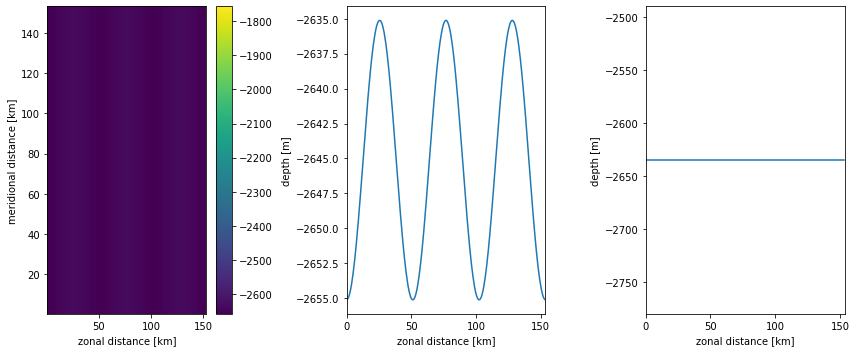

In [73]:
if rotatedFrame: mean_slope = 0.
else: mean_slope = np.tan(slopeAngle)

print("Slope angle is: "+np.str(slopeAngle))

Hbot = np.zeros_like(x)
Hbot[0,:,:] = x[0,:,:]*mean_slope
Hbot_flat = Hbot.copy()

if hills == 'x-hills': Hbot += (hill_height/2)*(1. + np.cos(np.pi + 2*np.pi*x/xhill_length))
elif hills == 'y-hills': Hbot += (hill_height/2)*(1. + np.cos(np.pi + 2*np.pi*y/yhill_length))
elif hills == 'xy-hills': Hbot += (hill_height/2)*(1. + 0.5*(np.cos(np.pi + 2*np.pi*x/xhill_length) + np.cos(np.pi + 2*np.pi*y/yhill_length)))

if canyon: Hbot += canyon_depth*(1. - np.exp( -(y-Ly/2)**2 / (2*canyon_width**2)))
    
Hbot = Hbot - (Hz - dz0)
Hbot_flat = Hbot_flat - (Hz - dz0)
if not(rotatedFrame): Hbot[:,:,0] = 0; Hbot[:,:,-1] = 0;

if plotting:
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.pcolor(x[0,:,:]*1e-3,y[0,:,:]*1e-3,Hbot[0,:,:])
    plt.xlabel('zonal distance [km]')
    plt.ylabel('meridional distance [km]')
    plt.colorbar()
    plt.clim([np.min(z),np.min(z)+900])

    plt.subplot(1,3,2)
    plt.plot(x[0,0,:]*1e-3,Hbot[0,ny//2,:])
    plt.xlim([0,nx*dx*1e-3])
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')

    plt.subplot(1,3,3)
    plt.plot(y[0,:,0]*1e-3,Hbot[0,:,nx//2])
    plt.xlim([0,ny*dy*1e-3])
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    
    plt.tight_layout()
    plt.show()



### Load initial condition

In [63]:
output_path = '../../data/dedalus/basic_state'

import h5py
f = h5py.File(output_path+"/output.h5", 'r')

data = f['tasks']
z_1d = data['b'].dims[1]['z/1.0'][:]
zf_1d = data['bz'].dims[1]['z/1.0'][:]

b_1d = data['b'][-1,:]
u_1d = data['u'][-1,:]
v_1d = data['v'][-1,:]
bz_1d = data['bz'][-1,:]

T_1d = b_1d/(gravity*tAlpha)

Temperature Lapse Rate is: 0.0008613659531090722


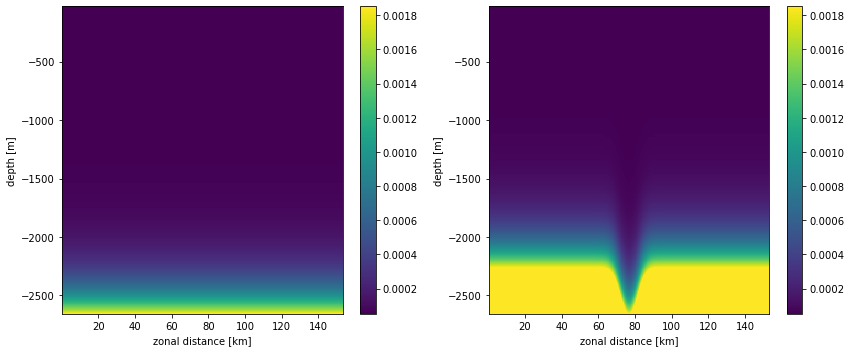

In [64]:
gamma = (N**2)/(gravity*tAlpha)
gamma_eps = gamma*1.e-4

if Uinit:
    U = np.interp(z - Hbot_flat, z_1d, u_1d)
    V = np.interp(z - Hbot_flat, z_1d, v_1d)
else:
    U = np.zeros((nz, ny, nx))
    V = np.zeros((nz, ny, nx))
if rest:
    T = np.zeros((nz, ny, nx))
else:
    if not(rotatedFrame): T = gamma * (z+Hz);
    else: T = np.interp(z - Hbot_flat, z_1d, T_1d)

T += np.random.normal(size=(nz, ny, nx),scale=2.e-8)/(gravity*tAlpha) # Callies2018 initial perturbation

print("Temperature Lapse Rate is: "+np.str((N**2)/(gravity*tAlpha)))

# generate 3D vertical eddy diffusivity field
K = np.zeros((nz,ny,nx))
for i in range(nx):
    for j in range(ny):
        K[:, j, i] = k0 + k1*np.exp(-(z[:,0,0] - Hbot[0,j,i])/d)
K[K>(k1+k0)] = k1+k0

if plotting:
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.pcolor(x[:,0,:]*1e-3,z[:,0,:],K[:,ny//2,:])
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.pcolor(y[:,:,0]*1e-3,z[:,:,0],K[:,:,nx//2])
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

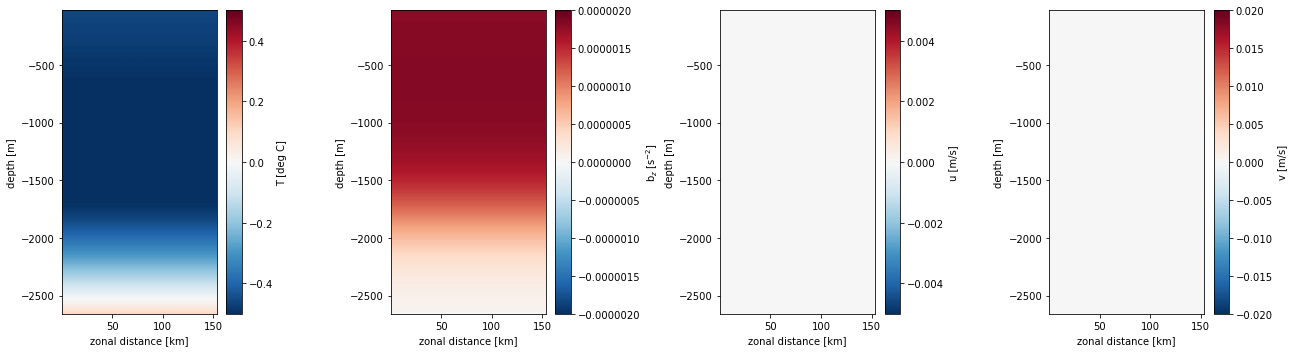

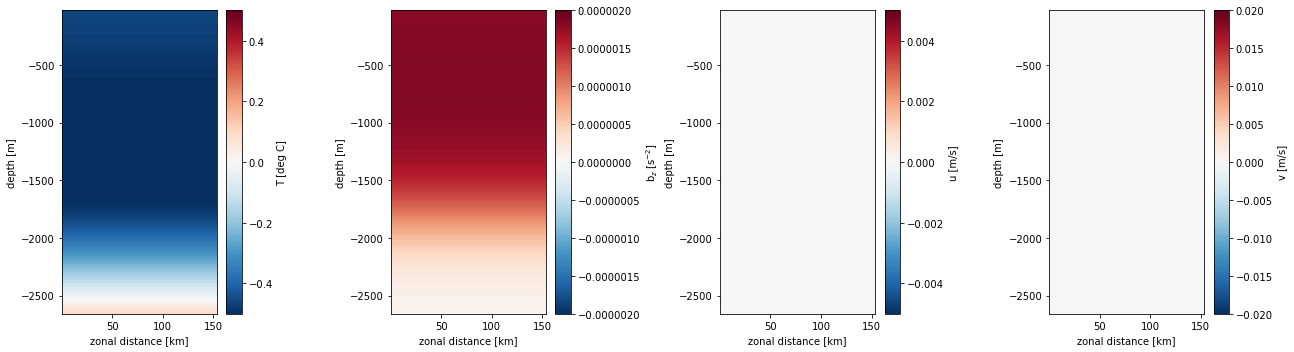

In [65]:
if plotting:
    plt.figure(figsize=(18,5))
    
    plt.subplot(1,4,1)
    plt.pcolor(x[:,0,:]*1e-3,z[:,0,:],T[:,ny//2,:], cmap='RdBu_r')
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar(label='T [deg C]')
    plt.clim([-0.5,0.5])
    
    plt.subplot(1,4,2)
    if rest:
        bz = np.zeros((nz, ny, nx))
    else:
        bz = np.interp(z - Hbot_flat, z_1d, bz_1d)
    plt.pcolor(x[:,0,:]*1e-3,z[:,0,:],bz[:,ny//2,:]+N**2, cmap='RdBu_r')
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar(label=r'b$_{z}$ [s$^{-2}$]')
    plt.clim([-2e-6,2e-6])
    
    plt.subplot(1,4,3)
    plt.pcolor(x[:,0,:]*1e-3,z[:,0,:],U[:,ny//2,:], cmap='RdBu_r')
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar(label='u [m/s]')
    plt.clim([-0.005,0.005])
    
    plt.subplot(1,4,4)
    plt.pcolor(x[:,0,:]*1e-3,z[:,0,:],V[:,ny//2,:], cmap='RdBu_r')
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar(label='v [m/s]')
    plt.clim([-0.02,0.02])
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(18,5))
    plt.subplot(1,4,1)
    plt.pcolor(y[:,:,0]*1e-3,z[:,:,0],T[:,:,nx//2], cmap='RdBu_r')
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar(label='T [deg C]')
    plt.clim([-0.5,0.5])
    
    plt.subplot(1,4,2)
    plt.pcolor(y[:,:,0]*1e-3,z[:,:,0],bz[:,:,nx//2]+N**2, cmap='RdBu_r')
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar(label=r'b$_{z}$ [s$^{-2}$]')
    plt.clim([-2e-6,2e-6])
    
    plt.subplot(1,4,3)
    plt.pcolor(y[:,:,0]*1e-3,z[:,:,0],U[:,:,nx//2], cmap='RdBu_r')
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar(label='u [m/s]')
    plt.clim([-0.005,0.005])
    
    plt.subplot(1,4,4)
    plt.pcolor(y[:,:,0]*1e-3,z[:,:,0],V[:,:,nx//2], cmap='RdBu_r')
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar(label='v [m/s]')
    plt.clim([-0.02,0.02])
    
    plt.tight_layout()
    plt.show()

In [66]:
# Reverse vertical axis so first index is at the surface and transpose axes
U = U[::-1,:,:]
V = V[::-1,:,:]
T = T[::-1,:,:]
K = K[::-1,:,:]
dz = dz[::-1,:1,:1]

# save input data as binary files
newFile = open(input_path+"U.init", "wb")
newFile.write(bytes(U.astype('>f8')))
newFile.close()

newFile = open(input_path+"V.init", "wb")
newFile.write(bytes(V.astype('>f8')))
newFile.close()

newFile = open(input_path+"T.init", "wb")
newFile.write(bytes(T.astype('>f8')))
newFile.close()

newFile = open(input_path+"kappa.init", "wb")
newFile.write(bytes(K.astype('>f8')))
newFile.close()

newFile = open(input_path+"topog.init", "wb")
newFile.write(bytes(Hbot[0,:,:].astype('>f8')))
newFile.close()

newFile = open(input_path+"delZ.init", "wb")
newFile.write(bytes(dz[:,0,0].astype('>f8')))
newFile.close()

In [67]:
import os
os.system(f"cp ./gendata_bbl_steady.ipynb {input_path}");